# Section C

1. Data Preparation: Use PyTorch to load the CIFAR-10 dataset, perform a
stratified random split in the ratio of 0.8:0.2 for the training and validation datasets.
Here, the 15,000 images from the training dataset are split into train-val via 0.8:0.2
split, and 3,000 images (1,000 per class) are retained as the testing data from the
original test dataset of CIFAR-10. Create a custom Dataset class for the data and
create data loaders for all the dataset splits - train, val, and test.

In [1]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

In [2]:
class CIFAR10Dataset:
    def __init__(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        self.cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        
    def split_data(self):
        class_indices = {0, 1, 2}
        train_indices = [i for i, (_, label) in enumerate(self.cifar10_train) if label in class_indices]
        test_indices = [i for i, (_, label) in enumerate(self.cifar10_test) if label in class_indices]
        train_data = Subset(self.cifar10_train, train_indices)
        test_data = Subset(self.cifar10_test, test_indices)
        targets = [train_data[i][1] for i in range(len(train_data))]
        train_idx, val_idx = train_test_split(range(len(train_data)), test_size=0.2, stratify=targets)
        train_split = Subset(train_data, train_idx)
        val_split = Subset(train_data, val_idx)
        return train_split, val_split, test_data
    
    def get_data_loaders(self, batch_size = 64):
        train_split, val_split, test_data = self.split_data()
        train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        return train_loader, val_loader, test_loader
    
    def loader_stats(self, loader):
        exact_samples = sum(len(batch[0]) for batch in loader)
        return exact_samples

In [3]:
dataset = CIFAR10Dataset()
train_loader, val_loader, test_loader = dataset.get_data_loaders()
print("Train samples: ", dataset.loader_stats(train_loader))
print("Validation samples: ", dataset.loader_stats(val_loader))
print("Test samples: ", dataset.loader_stats(test_loader))

Files already downloaded and verified
Files already downloaded and verified
Train samples:  12000
Validation samples:  3000
Test samples:  3000


2. Visualization: Load the dataset and visualize 5 images of each class
from both the training and validation datasets.

In [4]:
def imshow(img, ax):
    img = img / 2 + 0.5
    np_img = img.numpy()
    ax.imshow(np.transpose(np_img, (1, 2, 0)))
    ax.axis('off')

def visualize_samples(loader, class_names, num_samples=5):
    class_counts = {i: 0 for i in range(len(class_names))}
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(num_samples * 2, len(class_names) * 2))
    axes = axes.flatten().reshape(len(class_names), num_samples)

    for images, labels in loader:
        for img, lbl in zip(images, labels):
            lbl_index = lbl.item()
            if lbl_index in class_counts and class_counts[lbl_index] < num_samples:
                ax = axes[lbl_index, class_counts[lbl_index]]
                imshow(img, ax)
                class_counts[lbl_index] += 1
                if sum(class_counts.values()) >= len(class_names) * num_samples:
                    break
        if sum(class_counts.values()) >= len(class_names) * num_samples:
            break

    for i, class_name in enumerate(class_names):
        axes[i, 0].set_ylabel(class_name, rotation=0, size='large', labelpad=40)

    plt.tight_layout()
    plt.show()

In [5]:
classes = ['airplane', 'automobile', 'bird']

Training Data Samples:


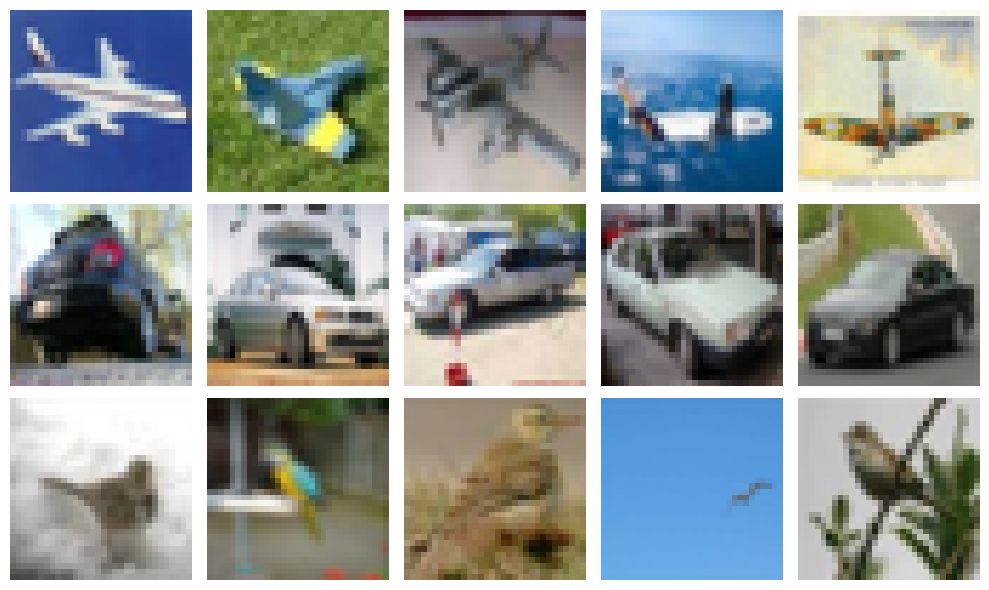

In [6]:
print("Training Data Samples:")
visualize_samples(train_loader, classes)

Validation Data Samples:


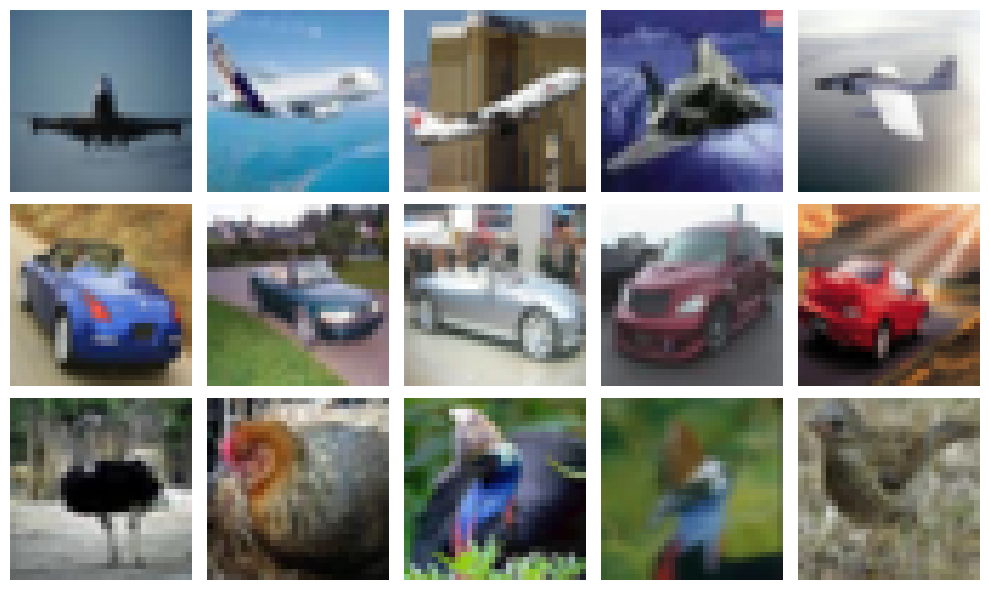

In [7]:
print("Validation Data Samples:")
visualize_samples(val_loader, classes)

3. CNN Implementation: Create a CNN architecture with 2 convolutional
layers (using in-built PyTorch implementations) having a kernel size of 5 x 5, 16
channels, padding and stride of 1 for the first layer, and kernel size of 3 x 3, 32
channels, stride of 1, and padding of 0 for the second layer. Use max-pooling layers
with a kernel size of 3 x 3 with a stride of 2 after the first convolutional layer
and a kernel size of 3 x 3 with stride 3 after the second convolutional layer. After
the second max pooling layer, flatten out the output and add it to a multi-layer
perceptron, with 16 neurons in the first layer and the classification head as the
second layer. Use the ReLU activation function after each layer other than the last
layer (the classification head layer).

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc1 = nn.Linear(32 * 4 * 4, 16) 
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

4. Training the model: Train the model using the cross-entropy loss function with Adam optimizer for 15 epochs. Log the training and validation loss and
accuracy after each epoch. Save the trained models as .pth files, which are to be
submitted along with the code for the assignment.

In [9]:
def train(model, train_loader, val_loader, epochs=15):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [10]:
cnn_model = CNNModel()
train_losses, train_accuracies, val_losses, val_accuracies = train(cnn_model, train_loader, val_loader)
torch.save(cnn_model.state_dict(), "cnn_model.pth")

Epoch [1/15], Train Loss: 0.6805, Train Accuracy: 0.7159, Val Loss: 0.5426, Val Accuracy: 0.7887
Epoch [2/15], Train Loss: 0.5147, Train Accuracy: 0.7972, Val Loss: 0.4870, Val Accuracy: 0.8077
Epoch [3/15], Train Loss: 0.4630, Train Accuracy: 0.8192, Val Loss: 0.4489, Val Accuracy: 0.8320
Epoch [4/15], Train Loss: 0.4227, Train Accuracy: 0.8351, Val Loss: 0.4210, Val Accuracy: 0.8380
Epoch [5/15], Train Loss: 0.3904, Train Accuracy: 0.8484, Val Loss: 0.3992, Val Accuracy: 0.8507
Epoch [6/15], Train Loss: 0.3609, Train Accuracy: 0.8588, Val Loss: 0.3866, Val Accuracy: 0.8517
Epoch [7/15], Train Loss: 0.3428, Train Accuracy: 0.8676, Val Loss: 0.3482, Val Accuracy: 0.8733
Epoch [8/15], Train Loss: 0.3268, Train Accuracy: 0.8725, Val Loss: 0.3434, Val Accuracy: 0.8687
Epoch [9/15], Train Loss: 0.3065, Train Accuracy: 0.8796, Val Loss: 0.3384, Val Accuracy: 0.8727
Epoch [10/15], Train Loss: 0.2920, Train Accuracy: 0.8862, Val Loss: 0.3431, Val Accuracy: 0.8703
Epoch [11/15], Train Loss: 0.

5. Testing: Observe the training and validation plots for loss and accuracy
and comment on your understanding of the results. Report the accuracy and F1-
score on the test dataset. Plot the confusion matrix for the train, val and test
dataset.

In [11]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()     

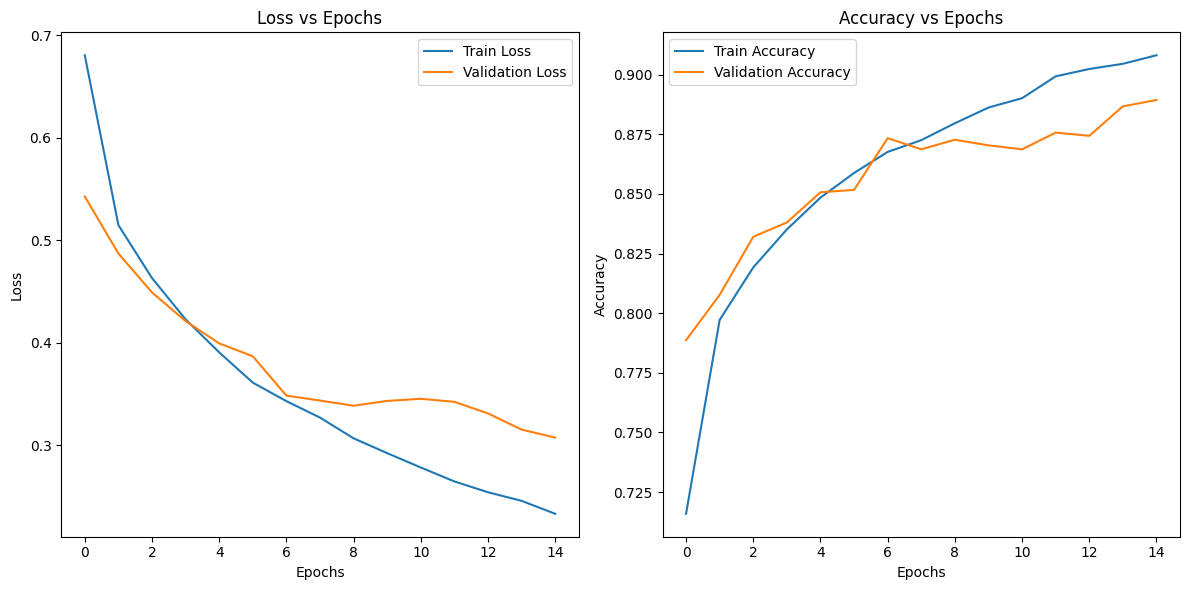

In [12]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

In [13]:
def test_model(model, dataloader):
    criterion = CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct / total
    test_f1 = f1_score(all_labels, all_preds, average="weighted")
    return test_loss / len(dataloader), test_acc, test_f1, all_preds, all_labels

In [14]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [31]:
# Loading the model
# cnn_model = CNNModel()
# cnn_model.load_state_dict(torch.load("cnn_model.pth"))
# cnn_loss, cnn_acc, cnn_f1, cnn_preds, cnn_labels = test_model(cnn_model, test_loader)
# print(f"Test Loss: {cnn_loss:.4f}, Test Accuracy: {cnn_acc * 100:.4f}%, F1-Score: {cnn_f1:.4f}")

In [15]:
cnn_loss, cnn_acc, cnn_f1, cnn_preds, cnn_labels = test_model(cnn_model, test_loader)
print(f"Test Loss: {cnn_loss:.4f}, Test Accuracy: {cnn_acc * 100:.4f}%, F1-Score: {cnn_f1:.4f}")

Test Loss: 0.3079, Test Accuracy: 88.3667%, F1-Score: 0.8839


Confusion Matrix for Testing Dataset

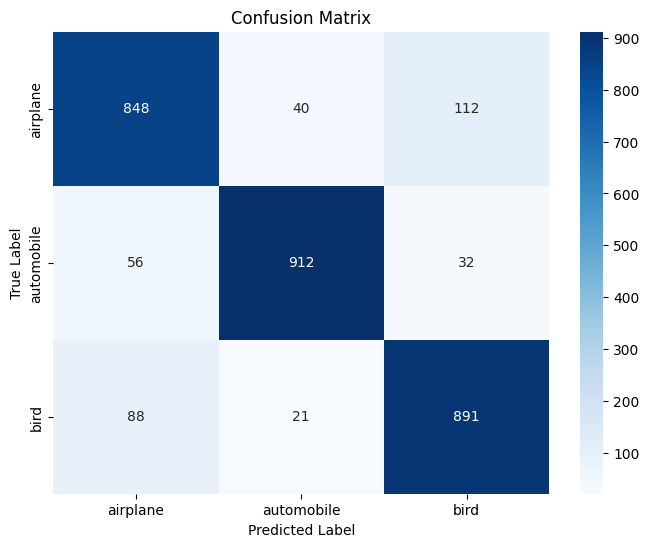

In [16]:
plot_confusion_matrix(cnn_labels, cnn_preds, class_names=["airplane", "automobile", "bird"])

Confusion Matrix for Training dataset

In [17]:
cnn_loss, cnn_acc, cnn_f1, cnn_preds, cnn_labels = test_model(cnn_model, train_loader)
print(f"Train Loss: {cnn_loss:.4f}, Train Accuracy: {cnn_acc * 100:.4f}%, F1-Score: {cnn_f1:.4f}")

Train Loss: 0.2078, Train Accuracy: 92.1750%, F1-Score: 0.9219


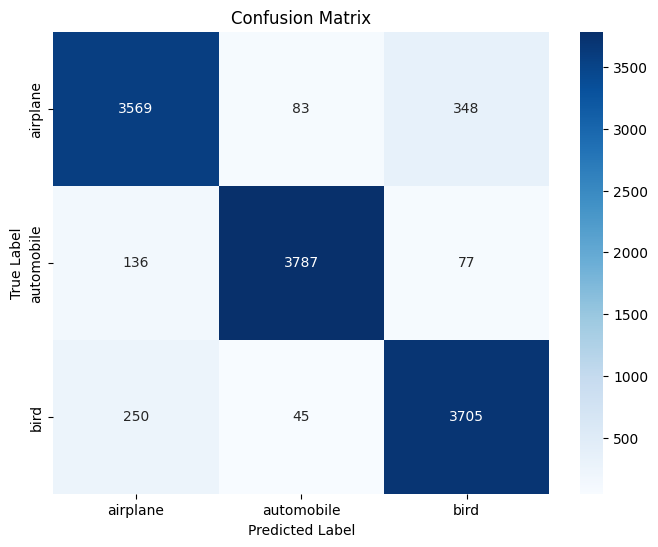

In [18]:
plot_confusion_matrix(cnn_labels, cnn_preds, class_names=["airplane", "automobile", "bird"])

Confusion Matrix for Validation Set

In [19]:
cnn_loss, cnn_acc, cnn_f1, cnn_preds, cnn_labels = test_model(cnn_model, val_loader)
print(f"Validation Loss: {cnn_loss:.4f}, Validation Accuracy: {cnn_acc * 100:.4f}%, F1-Score: {cnn_f1:.4f}")

Validation Loss: 0.3071, Validation Accuracy: 88.9333%, F1-Score: 0.8894


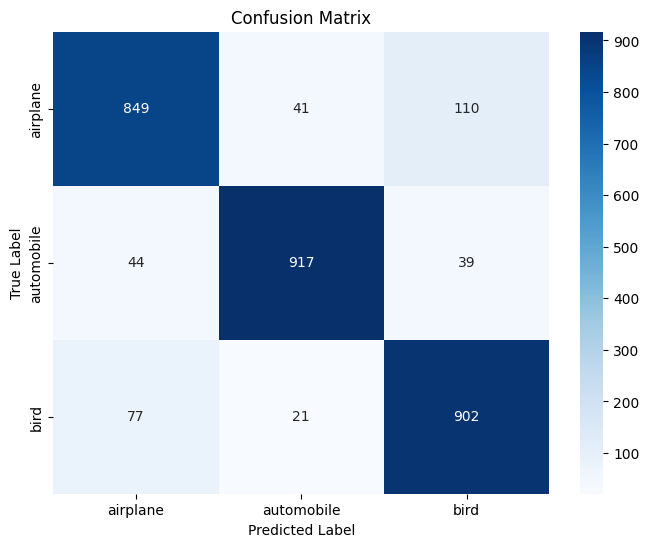

In [20]:
plot_confusion_matrix(cnn_labels, cnn_preds, class_names=["airplane", "automobile", "bird"])

6. Training an MLP: Create an MLP model with 2 fully connected layers,
the first layer with 64 neurons and the second layer as the classification head.
Flatten out the image before processing it into the MLP. Use a ReLU layer after
the first fully connected layer, and use the cross-entropy loss function with adam
optimizer to train the model for 15 epochs. Log the training and validation loss and
accuracy after each epoch. Save the models as .pth files, which must be submitted
along with the assignment.

In [21]:
class MLPModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [22]:
mlp_model = MLPModel(input_size=32*32*3, num_classes=3)
train_losses, train_accuracies, val_losses, val_accuracies = train(mlp_model, train_loader, val_loader)
torch.save(mlp_model.state_dict(), "mlp_model.pth")

Epoch [1/15], Train Loss: 0.6945, Train Accuracy: 0.7189, Val Loss: 0.6119, Val Accuracy: 0.7663
Epoch [2/15], Train Loss: 0.5692, Train Accuracy: 0.7735, Val Loss: 0.6550, Val Accuracy: 0.7283
Epoch [3/15], Train Loss: 0.5159, Train Accuracy: 0.8001, Val Loss: 0.5415, Val Accuracy: 0.7967
Epoch [4/15], Train Loss: 0.4651, Train Accuracy: 0.8215, Val Loss: 0.5459, Val Accuracy: 0.7900
Epoch [5/15], Train Loss: 0.4337, Train Accuracy: 0.8332, Val Loss: 0.5889, Val Accuracy: 0.7647
Epoch [6/15], Train Loss: 0.4047, Train Accuracy: 0.8464, Val Loss: 0.5817, Val Accuracy: 0.7740
Epoch [7/15], Train Loss: 0.3712, Train Accuracy: 0.8554, Val Loss: 0.5654, Val Accuracy: 0.7800
Epoch [8/15], Train Loss: 0.3523, Train Accuracy: 0.8671, Val Loss: 0.5789, Val Accuracy: 0.7933
Epoch [9/15], Train Loss: 0.3199, Train Accuracy: 0.8798, Val Loss: 0.5685, Val Accuracy: 0.7993
Epoch [10/15], Train Loss: 0.3028, Train Accuracy: 0.8860, Val Loss: 0.5615, Val Accuracy: 0.8083
Epoch [11/15], Train Loss: 0.

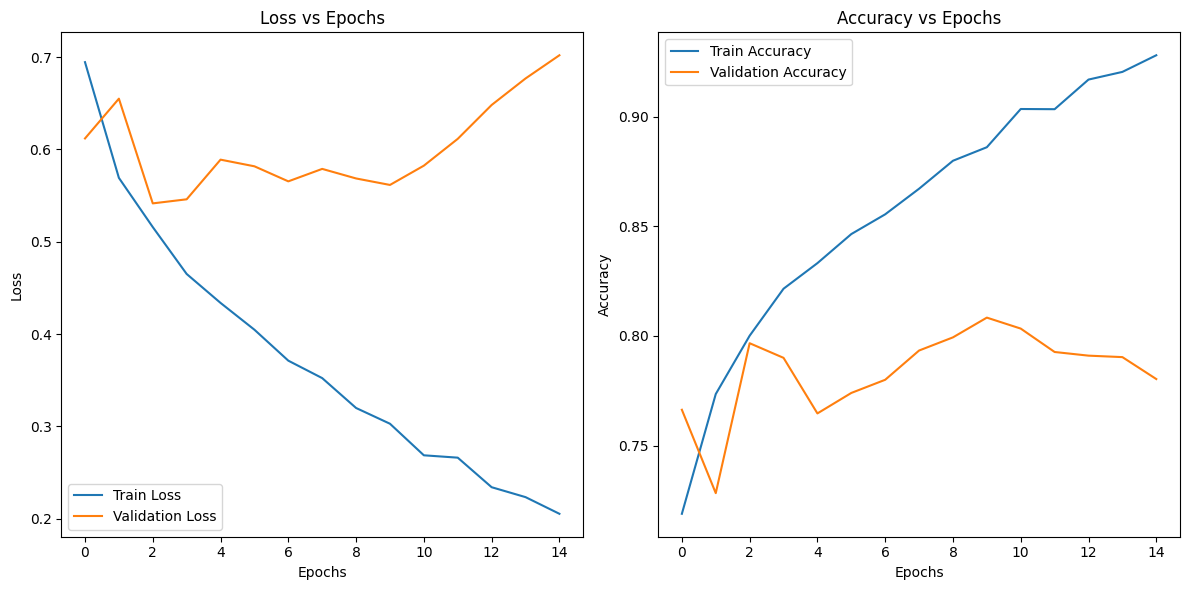

In [23]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

In [33]:
# Loading the model
# mlp_model = MLPModel(input_size=32*32*3, num_classes=3)
# mlp_model.load_state_dict(torch.load("mlp_model.pth"))
# mlp_loss, mlp_acc, mlp_f1, mlp_preds, mlp_labels = test_model(mlp_model, test_loader)
# print(f"Testing Loss: {mlp_loss:.4f}, Testing Accuracy: {mlp_acc * 100:.4f}%, F1-Score: {mlp_f1:.4f}")

7. Infer and Compare: Compute the test accuracy and F1-score and plot the
confusion matrix for the MLP model. Now, compare the results and plots obtained
from both the models and comment on their performance and differences.

Confusion Matrix for Training Dataset

In [24]:
mlp_loss, mlp_acc, mlp_f1, mlp_preds, mlp_labels = test_model(mlp_model, train_loader)
print(f"Training Loss: {mlp_loss:.4f}, Training Accuracy: {mlp_acc * 100:.4f}%, F1-Score: {mlp_f1:.4f}")

Training Loss: 0.2044, Training Accuracy: 93.0833%, F1-Score: 0.9311


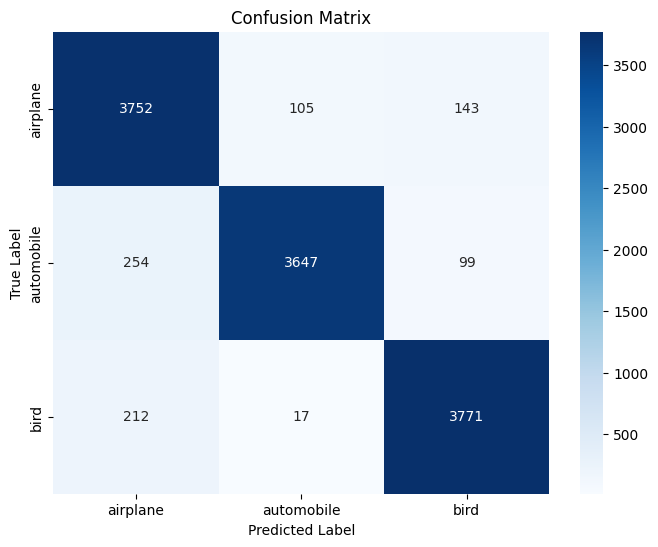

In [25]:
plot_confusion_matrix(mlp_labels, mlp_preds, class_names=["airplane", "automobile", "bird"])

Confusion Matrix for Testing Dataset

In [26]:
mlp_loss, mlp_acc, mlp_f1, mlp_preds, mlp_labels = test_model(mlp_model, test_loader)
print(f"Testing Loss: {mlp_loss:.4f}, Testing Accuracy: {mlp_acc * 100:.4f}%, F1-Score: {mlp_f1:.4f}")

Testing Loss: 0.6888, Testing Accuracy: 78.3333%, F1-Score: 0.7841


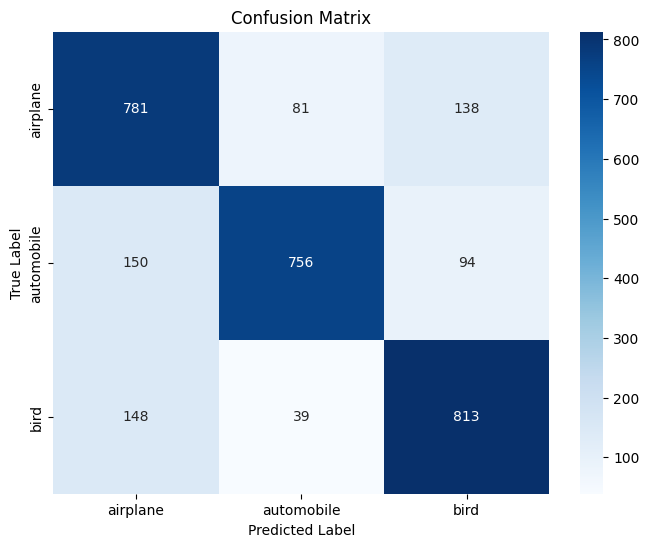

In [27]:
plot_confusion_matrix(mlp_labels, mlp_preds, class_names=["airplane", "automobile", "bird"])

Confusion Matrix for Validation Dataset

In [28]:
mlp_loss, mlp_acc, mlp_f1, mlp_preds, mlp_labels = test_model(mlp_model, val_loader)
print(f"Validation Loss: {mlp_loss:.4f}, Validation Accuracy: {mlp_acc * 100:.4f}%, F1-Score: {mlp_f1:.4f}")

Validation Loss: 0.7024, Validation Accuracy: 78.0333%, F1-Score: 0.7808


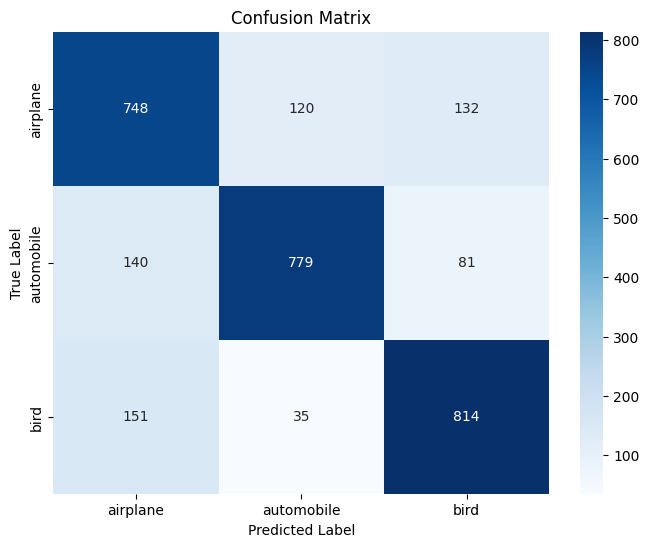

In [29]:
plot_confusion_matrix(mlp_labels, mlp_preds, class_names=["airplane", "automobile", "bird"])